In [1]:
import os
os.chdir("../")

In [2]:
!pip install -q catboost

     |████████████████████████████████| 76.1 MB 50 kB/s 


In [3]:
import os

import numpy as np 

import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns

from tqdm import tqdm

from statistics import mode 
from scipy.stats import mode as scp_mode

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import mean_squared_error

In [4]:
skf = StratifiedKFold(n_splits = 5,
                              # random_state=199
                      )

def metric(x, y):
    """
    Custom metric function
    
    Input:
    x: true target value
    y: predicted value
    
    Output: 
    error: rmse between the real value and the predicted one.    
    """
    
    error = mean_squared_error(x, y, squared=False)
    
    return error

In [5]:
def cat_predict(estimator,train,label,test,estimator_name, groups, cat):
    """
    Train function for managing overfitting and using the best iteration with xgboost model.
    
    Input:
    estimator: CatboostRegressor instance model
    train: Design matrix in pandas dataframe format for the learning phase
    label: Target variable in pandas data series format
    test: Design matrix in pandas dataframe format for the prediction phase
    estimator_name: Name of the model being created
    skf: crossvalidation scheme instance; in this case, RepeatedStratifiedKFold
    cat: Discrete Target Variable for the cross validation step
    groups: Categories also for some cross validation scheme. 
    
    Output:
    val_pred: Numpy array containing predictions for the train set
    test_pred: Numpy array containg predictions for the test set
    estimator_name: model name
    """
    
    mean_train = []
    mean_test_val = []
    test_pred = np.zeros(test.shape[0])
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train, cat, groups)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
        x_train = np.nan_to_num(x_train)
        y_train = np.nan_to_num(y_train)
        x_test = np.nan_to_num(x_test)
        y_test = np.nan_to_num(y_test)
        
        print(f'========================Fold{count +1}==========================')
        estimator.fit(x_train,y_train,eval_set=[(x_test,y_test)],early_stopping_rounds=200,
                           verbose=2500,use_best_model=True)
        train_predict = estimator.predict(x_train)
        test_predict = estimator.predict(x_test)
        val_pred[test_index] = test_predict
        test_pred+= estimator.predict(test)
        
        print('\nTesting scores', metric(y_test,test_predict))
        print('\nTraining scores', metric(y_train,train_predict))
        mean_train.append(metric(y_train, train_predict))
        mean_test_val.append(metric(y_test,test_predict))
    print('Average Testing ROC score for 5 folds split:',np.mean(mean_test_val))
    print('Average Training ROC score for 5 folds split:',np.mean(mean_train))
    print('standard Deviation for 5 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name


In [6]:
train_df = pd.read_csv("https://storage.googleapis.com/umojahack2022/train.csv")
test_df = pd.read_csv("https://storage.googleapis.com/umojahack2022/test.csv")

In [7]:
train_df.head()

,ID,Toxin_UniprotID,Kmer_Position_start,Kmer_Position_end,Antivenom,Toxin_Kmer,Signal,Genus,Species,ProteinFam,ProteinSubFam,ProteinSubSubFam
0,P07037_Bioclone_1,P07037,1,16,Bioclone,NLYQFKNMIQCTVPNR,-0.53,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
1,P07037_Bioclone_2,P07037,2,17,Bioclone,LYQFKNMIQCTVPNRS,-1.00,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
2,P07037_Bioclone_3,P07037,3,18,Bioclone,YQFKNMIQCTVPNRSW,-0.21,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
3,P07037_Bioclone_4,P07037,4,19,Bioclone,QFKNMIQCTVPNRSWW,-0.30,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
4,P07037_Bioclone_5,P07037,5,20,Bioclone,FKNMIQCTVPNRSWWH,-1.00,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily


In [8]:
train_df.Toxin_Kmer.apply(len).unique()

array([16])

In [9]:
train_df.Toxin_Kmer.nunique()

11954

In [10]:
train_df.shape

(124117, 12)

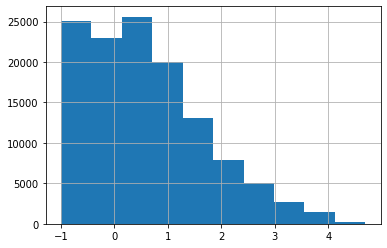

In [11]:
train_df["Signal"].hist()

In [12]:
train_df["Signal"].describe()

count    124117.000000
mean          0.581283
std           1.130208
min          -1.000000
25%          -0.270000
50%           0.440000
75%           1.260000
max           4.690000
Name: Signal, dtype: float64

In [13]:
train_df["Toxin_Kmer"].apply(list).apply(scp_mode)

0         ([N], [3])
1         ([N], [2])
2         ([N], [2])
3         ([N], [2])
4         ([N], [2])
             ...    
124112    ([D], [3])
124113    ([P], [3])
124114    ([P], [3])
124115    ([P], [3])
124116    ([P], [3])
Name: Toxin_Kmer, Length: 124117, dtype: object

In [14]:
scp_mode(list(train_df["Toxin_Kmer"][0]))

ModeResult(mode=array(['N'], dtype='<U1'), count=array([3]))

In [15]:
toxin_kmer_sple = train_df["Toxin_Kmer"][0]
toxin_kmer_sple

'NLYQFKNMIQCTVPNR'

In [16]:
amino_acid_map = {'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'V': 17,
 'W': 18,
 'Y': 19}

In [17]:
toxin_map = {k:[0]*16 for k in amino_acid_map.keys()}

In [18]:
toxin_map

{'A': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'C': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'D': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'E': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'F': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'G': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'H': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'I': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'K': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'L': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'M': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'N': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'P': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'R': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'S': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'T': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'V': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
for i, acide in enumerate(toxin_kmer_sple):
  toxin_map[acide][i] = 1

In [20]:
toxin_map

{'A': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'C': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'D': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'E': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'F': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'G': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'H': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'I': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'K': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'L': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'M': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'N': [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'P': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'Q': [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'R': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'S': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'T': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'V': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [21]:
np.array(list(toxin_map.values())).shape

(20, 16)

In [22]:
from itertools import product

In [23]:
names = ["".join([str(c) for c in x ])for x in list(product(list(amino_acid_map.keys()), range(16)))]

In [24]:
# train_df[names] = None

In [25]:
train_df.head()

,ID,Toxin_UniprotID,Kmer_Position_start,Kmer_Position_end,Antivenom,Toxin_Kmer,Signal,Genus,Species,ProteinFam,ProteinSubFam,ProteinSubSubFam
0,P07037_Bioclone_1,P07037,1,16,Bioclone,NLYQFKNMIQCTVPNR,-0.53,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
1,P07037_Bioclone_2,P07037,2,17,Bioclone,LYQFKNMIQCTVPNRS,-1.00,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
2,P07037_Bioclone_3,P07037,3,18,Bioclone,YQFKNMIQCTVPNRSW,-0.21,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
3,P07037_Bioclone_4,P07037,4,19,Bioclone,QFKNMIQCTVPNRSWW,-0.30,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
4,P07037_Bioclone_5,P07037,5,20,Bioclone,FKNMIQCTVPNRSWWH,-1.00,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily


In [26]:
def acid_processing(acid):

  toxin_map = {k:[0]*16 for k in amino_acid_map.keys()}

  for i, acide in enumerate(acid):
      toxin_map[acide][i] = 1

  return np.array(list(toxin_map.values())).ravel().tolist()

In [27]:
toxin_kmer_preprocessed = [acid_processing(x) for x in tqdm(train_df["Toxin_Kmer"].values.tolist())]

100%|██████████| 124117/124117 [00:07<00:00, 17290.51it/s]


In [28]:
toxin_kmer_preprocessed = pd.DataFrame(data = np.array(toxin_kmer_preprocessed), columns = names)

In [29]:
toxin_kmer_preprocessed.sum(axis=0)[toxin_kmer_preprocessed.sum(axis=0)==0]

Series([], dtype: int64)

In [30]:
toxin_kmer_preprocessed.var()[toxin_kmer_preprocessed.var()==0]

Series([], dtype: float64)

In [31]:
train_df.tail()

,ID,Toxin_UniprotID,Kmer_Position_start,Kmer_Position_end,Antivenom,Toxin_Kmer,Signal,Genus,Species,ProteinFam,ProteinSubFam,ProteinSubSubFam
124112,M5BGY5_VINS_Central_Africa_92,M5BGY5,92,107,VINS_Central_Africa,DMNDYCTGTTPDCPRN,1.06,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN
124113,M5BGY5_VINS_Central_Africa_93,M5BGY5,93,108,VINS_Central_Africa,MNDYCTGTTPDCPRNP,0.80,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN
124114,M5BGY5_VINS_Central_Africa_94,M5BGY5,94,109,VINS_Central_Africa,NDYCTGTTPDCPRNPY,0.43,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN
124115,M5BGY5_VINS_Central_Africa_95,M5BGY5,95,110,VINS_Central_Africa,DYCTGTTPDCPRNPYK,1.46,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN
124116,M5BGY5_VINS_Central_Africa_96,M5BGY5,96,111,VINS_Central_Africa,YCTGTTPDCPRNPYKD,1.47,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN


In [32]:
train_df.nunique()

ID                     124117
Toxin_UniprotID           237
Kmer_Position_start       594
Kmer_Position_end         594
Antivenom                   8
Toxin_Kmer              11954
Signal                    552
Genus                       8
Species                    30
ProteinFam                 16
ProteinSubFam              12
ProteinSubSubFam           24
dtype: int64

In [33]:
test_df.nunique()

ID                     36540
Toxin_UniprotID           60
Kmer_Position_start      472
Kmer_Position_end        472
Antivenom                  8
Toxin_Kmer              4251
Genus                      8
Species                   20
ProteinFam                12
ProteinSubFam             10
ProteinSubSubFam          17
dtype: int64

In [34]:
train_df.isna().sum()[train_df.isna().sum()!=0]

ProteinSubFam       48032
ProteinSubSubFam    62160
dtype: int64

In [35]:
def get_toxin_kmer(df):
  toxin_kmer_preprocessed = [acid_processing(x) for x in tqdm(df["Toxin_Kmer"].values.tolist())]
  toxin_kmer_preprocessed = pd.DataFrame(data = np.array(toxin_kmer_preprocessed), columns = names)
  return toxin_kmer_preprocessed

In [36]:
test_toxin_kmer = get_toxin_kmer(test_df)

100%|██████████| 36540/36540 [00:01<00:00, 18932.76it/s]


In [37]:
test_toxin_kmer.var()[test_toxin_kmer.var()==0]

Series([], dtype: float64)

In [38]:
pd.crosstab(train_df["Antivenom"], train_df["Genus"])

Genus,Aspidelaps,Atheris,Bitis,Dendroaspis,Dispholidus,Echis,Hemachatus,Naja
Antivenom,,,,,,,,
Bioclone,191,269,3251,2332,618,5142,438,3292
ICP,193,268,3252,2333,602,5127,438,3290
Inosan,192,267,3258,2333,604,5132,439,3290
Premium,193,268,3254,2333,603,5131,438,3286
SAVP,193,268,3254,2333,603,5131,438,3286
Sanofi_Pasteur,192,266,3254,2333,607,5134,439,3290
VINS_Africa,192,267,3255,2333,602,5132,439,3290
VINS_Central_Africa,191,267,3246,2333,615,5146,438,3293


In [39]:
train_index = train_df.shape[0]

In [40]:
groups = train_df["Toxin_UniprotID"]

In [41]:
cat_data = pd.get_dummies(pd.concat([train_df[['Antivenom', 'Genus', 'Species', 'ProteinFam']], test_df[['Antivenom', 'Genus', 'Species', 'ProteinFam']]], axis=0))

In [42]:
train_cat = cat_data[:train_index]
test_cat =cat_data[train_index:]

In [43]:
train_df.columns

Index(['ID', 'Toxin_UniprotID', 'Kmer_Position_start', 'Kmer_Position_end',
       'Antivenom', 'Toxin_Kmer', 'Signal', 'Genus', 'Species', 'ProteinFam',
       'ProteinSubFam', 'ProteinSubSubFam'],
      dtype='object')

In [44]:
train = pd.concat([toxin_kmer_preprocessed, train_cat, train_df[['Kmer_Position_start', 'Kmer_Position_end']]], axis=1)
label = train_df.Signal
test = pd.concat([test_toxin_kmer, test_cat, test_df[['Kmer_Position_start', 'Kmer_Position_end']]], axis=1)

In [45]:
train.shape, test.shape

((124117, 387), (36540, 387))

In [46]:
train.dtypes.unique()

array([dtype('int64'), dtype('uint8')], dtype=object)

In [47]:
test.dtypes.unique()

array([dtype('int64'), dtype('uint8')], dtype=object)

In [48]:
device_type = "GPU"

In [49]:
catboost =  CatBoostRegressor(random_seed=34,
                              use_best_model=True,
                          n_estimators=5000,
                          silent=True,
                          eval_metric='RMSE', task_type=device_type,
                                  # learning_rate=0.7
                                 )

In [50]:
# rf = RandomForestRegressor(random_state=21)

In [51]:
# rf.fit(train, label)

In [52]:
# pred = rf.predict(test)

In [53]:
# cat1_train, cat1_test, cat1_name = cat_predict(catboost,train, label, test,  'catboost(1)', groups, train_df["Genus"])

In [55]:
# sample_submission=test_df[["ID"]]
# sample_submission["Signal"] = cat1_test/5
# sample_submission.to_csv("Submissions/cb2.csv",index=False)

In [56]:
# sample_submission["Signal"].hist()

In [57]:
train_df.Antivenom.value_counts()

Bioclone               15533
VINS_Central_Africa    15529
Inosan                 15515
Sanofi_Pasteur         15515
VINS_Africa            15510
Premium                15506
SAVP                   15506
ICP                    15503
Name: Antivenom, dtype: int64

In [59]:
biovlone_antivenom_data = train_df.loc[train_df.Antivenom == "Bioclone"]

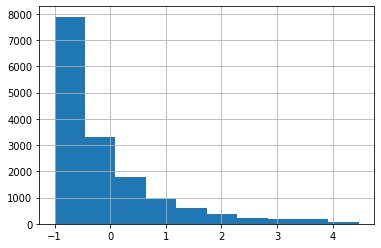

In [61]:
biovlone_antivenom_data.Signal.hist()

In [ ]:
def one_gram(kmer):
  count_acides_map = collections.Counter(kmer)
  default_acide_map = {k:0 for k in amino_acid_map.keys()}
  count_acides_map.update(default_acide_map)
  f_i_acides = {k:v for k, v in dict(count_acides_map).items()}
  return list(f_i_acides.values())

def get_one_grams(df):
  names = list(amino_acid_map.keys())
  toxin_kmer_preprocessed = [one_gram(x) for x in tqdm(df["Toxin_Kmer"].values.tolist())]
  toxin_kmer_preprocessed = pd.DataFrame(data = np.array(toxin_kmer_preprocessed), columns = names)
  return toxin_kmer_preprocessed

